In [80]:
import numpy as np
import cv2
import skimage
from skimage.transform import SimilarityTransform
from skimage.transform import warp
import scipy
import matplotlib.pyplot as plt
from skimage import color
from scipy import *
from pylab import *
from scipy import signal
from mpl_toolkits.mplot3d import Axes3D
from PIL import Image

In [89]:
left = cv2.imread("/content/left.jpeg")
right = cv2.imread("/content/right.jpeg")

In [90]:
left_1 = color.rgb2gray(left).astype(np.double)
left_2 = cv2.cvtColor(left, cv2.COLOR_BGR2GRAY)
right_1 = color.rgb2gray(right).astype(np.double)
right_2= cv2.cvtColor(right, cv2.COLOR_BGR2GRAY)

In [91]:
sift = cv2.xfeatures2d.SIFT_create()
#sift2 = cv2.xfeatures2d.SIFT_create()
keypoints_left, descriptors_left = sift.detectAndCompute(left_2, None)
keypoints_right, descriptors_right = sift.detectAndCompute(right_2, None)

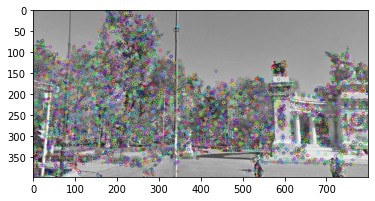

In [92]:
draw_keypoints_left = cv2.drawKeypoints(left_2, keypoints_left, None)
plt.imshow(draw_keypoints_left)
plt.show()

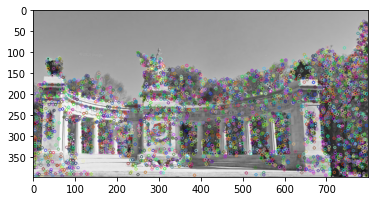

In [93]:
draw_keypoints_right = cv2.drawKeypoints(right_2, keypoints_right, None)
plt.imshow(draw_keypoints_right)
plt.show()

In [94]:
dist = scipy.spatial.distance.cdist(descriptors_left, descriptors_right, 'sqeuclidean')
min = np.sort(dist, axis = None)[:180]
points_left = []
points_right = []
for x in range(len(keypoints_left)):
    for y in range(len(keypoints_right)):
        if dist[x, y] in min:
            points_left.append(x)
            points_right.append(y)

In [99]:

# Implement RANSAC to estimate a homography mapping one image onto the other.
iterations = 3000
thresh = 5
Homography_list = []
inlier_final = []
residual_list = []
inlier_list = []
for c in range(iterations):
    # randomly select 4 matches
    shuffled_inliers = np.arange(180)
    np.random.shuffle(shuffled_inliers)
    list = shuffled_inliers[:4]
    
    x_left = []
    y_left = []
    
    x_right = []
    y_right = []
    for i in range(4):
        x_left.append(keypoints_left[points_left[list[i]]].pt[0])
        y_left.append(keypoints_left[points_left[list[i]]].pt[1])
        
        x_right.append(keypoints_right[points_right[list[i]]].pt[0])
        y_right.append(keypoints_right[points_right[list[i]]].pt[1])
    
    # Set up A
    matrix = np.array([
                    [0, 0, 0, x_left[0], y_left[0],1, -1 * y_right[0] * x_left[0],-1 * y_right[0] * y_left[0],-1 * y_right[0] * 1],
                    [x_left[0],y_left[0], 1,0 ,0 ,0 , -1 * x_right[0] * x_left[0]  ,-1 * x_right[0] * y_left[0] ,-1 * x_right[0] * 1],
                    [0,0 ,0 ,x_left[1] ,y_left[1] , 1,-1 * y_right[1] * x_left[1] ,-1 * y_right[1] * y_left[1] ,-1 * y_right[1] * 1],
                    [x_left[1],y_left[1] ,1 ,0 ,0 ,0 ,-1 * x_right[1] * x_left[1] ,-1 * x_right[1] * y_left[1] ,-1 * x_right[1] * 1],
                    [0, 0,0 ,x_left[2] ,y_left[2] , 1,-1 * y_right[2] * x_left[2] ,-1 * y_right[2] * y_left[2] ,-1 * y_right[2] * 1],
                    [x_left[2],y_left[2] ,1 ,0 ,0 ,0 ,-1 * x_right[2] * x_left[2] ,-1 * x_right[2] * y_left[2] ,-1 * x_right[2] * 1],
                    [0,0 ,0,x_left[3] , y_left[3],1 ,-1 * y_right[3] * x_left[3] ,-1 * y_right[3] * y_left[3] ,-1 * y_right[3] * 1],
                    [x_left[3],y_left[3] ,1 ,0 ,0 ,0 ,-1 * x_right[3] * x_left[3] ,-1 * x_right[3] * y_left[3] ,-1 * x_right[3] * 1]
                    ])


    # Solve for H
    U, s, V = np.linalg.svd(matrix)
    Homography_matrix  = V[-1,:]
    Homography_matrix = Homography_matrix.reshape((3,3))
    current_inlier_count = 0
    current_inlier_list = []
    inlier_residual_sum = 0
    
    # find inliers
    for i in shuffled_inliers[4: ]:
        x_left_original = keypoints_left[points_left[i]].pt[0]
        y_left_original = keypoints_left[points_left[i]].pt[1]
        x_right_original = keypoints_right[points_right[i]].pt[0]
        y_right_original = keypoints_right[points_right[i]].pt[1]
        
        mat = np.matmul(Homography_matrix, np.array([x_left_original, y_left_original, 1]))
        
        x_right_new = mat[0] / mat[2]
        y_right_new = mat[1] / mat[2]
        
        inlier_residual = (x_right_new - x_right_original) ** 2 + (y_right_new - y_right_original) ** 2
        
        if inlier_residual <= thresh:
            current_inlier_count += 1
            inlier_residual_sum += inlier_residual
            current_inlier_list.append(i)
            
    Homography_list.append(Homography_matrix)
    inlier_final.append(current_inlier_count)
    residual_list.append(inlier_residual_sum)
    inlier_list.append(current_inlier_list)
count =  inlier_final[np.argmax(inlier_final)]   
avg = residual_list[np.argmax(inlier_final)] / count    
print(" Inlier count: ", count)
print(" Residual avg: ", avg)
optimal_matrix  = Homography_list[np.argmax(inlier_final)]
optimal_inliers = inlier_list[np.argmax(inlier_final)]
print(optimal_inliers)

 Inlier count:  65
 Residual avg:  1.245095440060881
[103, 92, 120, 156, 101, 61, 165, 143, 152, 154, 148, 144, 121, 150, 110, 105, 142, 106, 178, 159, 97, 124, 113, 171, 116, 126, 122, 69, 127, 169, 138, 162, 136, 164, 131, 153, 94, 168, 133, 132, 139, 118, 130, 128, 175, 60, 149, 111, 114, 176, 112, 109, 158, 163, 160, 135, 146, 75, 137, 115, 85, 179, 99, 166, 119]


In [96]:

left_img = Image.open('/content/left.jpeg')
x = left_img.size[0]
y = left_img.size[1]
right_img = Image.open('/content/right.jpeg')

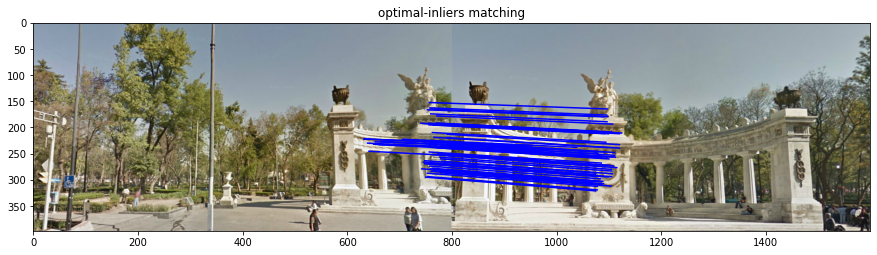

In [97]:
matches = []
for o in optimal_inliers:
   matches.append([keypoints_left[points_left[o]].pt[0],
                   keypoints_left[points_left[o]].pt[1],
                   keypoints_right[points_right[o]].pt[0],
                   keypoints_right[points_right[o]].pt[1]])
    
matches = np.array(matches)    
    
resulting_img = np.zeros((y,x*2,3) )
resulting_img[:,:x,:] = left_img;
resulting_img[:,x:,:] = right_img;
fig, ax = plt.subplots(figsize=(15,10))
ax.set_title('optimal-inliers matching')
ax.imshow(np.array(resulting_img/255))
ax.plot([matches[:,0], matches[:,2]+x],[matches[:,1], matches[:,3]], 'b')
plt.show()


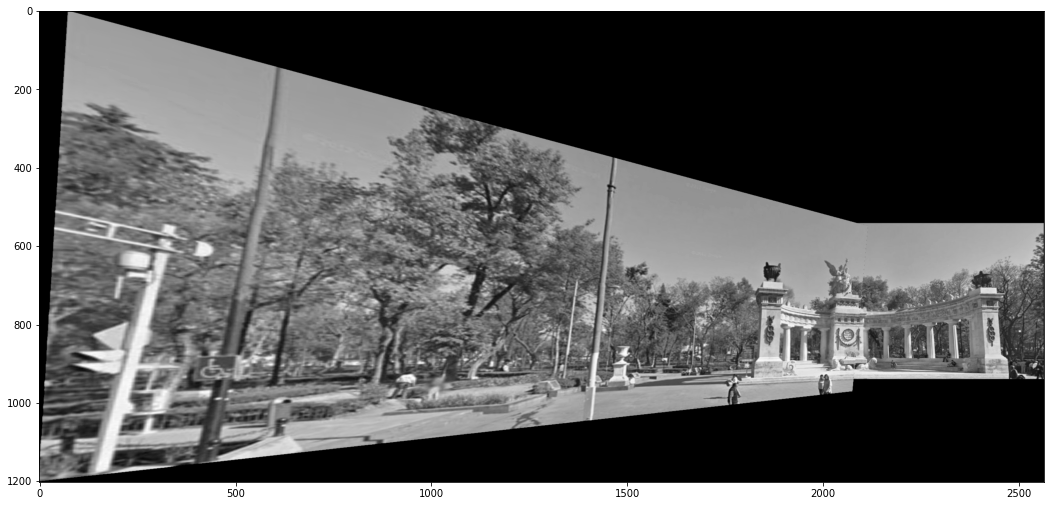

In [98]:
def image_warping(left_1, right_1, transform):
    row, col = left_1.shape[:2]
    corners = np.array([[0, 0],
                        [0, row],
                        [col, 0],
                        [col, row]])
    corners_after_warping = transform(corners)
    new_corners = np.vstack((corners_after_warping, corners))
    min = np.min(new_corners, axis=0)
    max = np.max(new_corners, axis=0)
    resulting_img_shape = (max - min)
    resulting_img_shape = np.ceil(resulting_img_shape[::-1])
    offset = SimilarityTransform(translation=-min)
    right_1_ = warp(right_1, offset.inverse, output_shape=resulting_img_shape, cval=-1)
    left_1_ = warp(left_1, (transform + offset).inverse, output_shape=resulting_img_shape, cval=-1)
    right_1_zeros = warp(right_1, offset.inverse, output_shape=resulting_img_shape, cval=0)
    left_1_zeros = warp(left_1, (transform + offset).inverse, output_shape=resulting_img_shape, cval=0)
    attached = right_1_zeros * ((left_1_ < 0.02).astype(int)) + left_1_zeros * ((left_1_ >= 0.02).astype(int))
    plt.figure(figsize = (18, 18))
    plt.imshow(attached, cmap = 'gray')

image_transformation = skimage.transform.ProjectiveTransform(optimal_matrix )
image_warping(left_1, right_1, image_transformation)